# Sentencing

In [1]:
# This Python file uses the following encoding: utf-8
import os
from lib.words import not_so_naive_split, replace_evil_dots_and_underscores, tokenize_doc
from lib.parallel_run import parallel_run
import numpy as np
import codecs

Divisione del testo in frasi, rimozione di stop words, numeri, punteggiatura...

In [5]:
# Esempio di split

t = not_so_naive_split(text, split='.')
#t

In [3]:

# old, no utf-8...
def sentence_splitting(src_dir, out_dir, digit_replacement='NUM', split='.', min_words=2, max_n=-1):
    i = 0
    for f in os.listdir(src_dir):
        txt = open(src_dir+'/'+f).read()
        splitted = not_so_naive_split(txt, digit_replacement, split, min_words)
        with open(out_dir+'/'+f, 'w') as of:
            for l in splitted:
                of.write(' '.join(l)+'\n')
        if max_n>0 and i >= max_n:
            break
        i += 1
        
def sentence_tokenize_file(f, src_dir, out_dir, min_words=2):
    txt = open(src_dir+'/'+f).read()
    splitted = tokenize_doc(txt, min_words)
    with codecs.open(out_dir+'/'+f, 'w', 'utf-8') as of:
        for l in splitted:
            of.write(u' '.join(l)+u'\n')
        
def sentence_tokenization(src_dir, out_dir, min_words=2):
    for f in os.listdir(src_dir):
        txt = open(src_dir+'/'+f).read()
        splitted = tokenize_doc(txt, min_words)
        with codecs.open(out_dir+'/'+f, 'w', 'utf-8') as of:
            for l in splitted:
                of.write(u' '.join(l)+u'\n')

In [15]:
# Per atti costitutivi
sentence_splitting('../atti_costitutivi_txt','../atti_costitutivi_sentences')

In [4]:
sentence_tokenization('../atti_costitutivi_txt','../atti_costitutivi_sentences')

In [5]:
# Per atti non costitutivi
#sentence_splitting('../atti_non_costitutivi_txt2','../atti_non_costitutivi_sentences')
sentence_tokenization('../atti_non_costitutivi_txt','../atti_non_costitutivi_sentences')

In [4]:
# Per atti non costitutivi scansionati
sentence_splitting('../ocr/scanned_non_costitutivi','../atti_non_costitutivi_sentences')

In [3]:
# Esempio di testo elaborato

text = open('../atti_non_costitutivi_sentences/'+'4578843770001.txt').read()
print text

## Conversione in CSV

In [6]:
def folders_to_csv(csv_file, dirs, labels):
    '''
    Writes to a csv file the lines contained in a list of directories,
    assuming each directory is associated to one label'''
    with codecs.open(csv_file,'w', 'utf-8') as out_file:
        out_file.write('filename,sentence,label\n')
        for d, label in zip(dirs, labels):
            for f in os.listdir(d):
                with codecs.open(d+u'/'+f, 'r', 'utf-8') as in_file:
                    for line in in_file:
                        out_file.write((u','.join([f[:-4],line.strip(),label]))+u'\n')
 

In [7]:
folders_to_csv('../atti.csv', ['../atti_costitutivi_sentences/', '../atti_non_costitutivi_sentences/'], ['costitutivo','non_costitutivo'])

## Statistiche PANDAS

In [8]:
import pandas as pd
from matplotlib import pyplot as plt

In [14]:
def print_column_stats(col):
    print 'Mean', col.mean()
    print 'Stddev', col.std()
    print 'Min', col.min()
    print 'Max', col.max()

In [9]:
df = pd.read_csv("../atti.csv", encoding='utf-8')
#df

In [11]:
df_nc = df.loc[df['label'] == 'non_costitutivo']
df_c = df.loc[df['label'] == 'costitutivo']

## Distribuzione numero parole per linea

In [12]:
s_len = df['sentence'].apply(lambda s:len(s.split()))

In [15]:
print_column_stats(s_len)

Mean 20.7858533677
Stddev 30.4349362383
Min 2
Max 13599


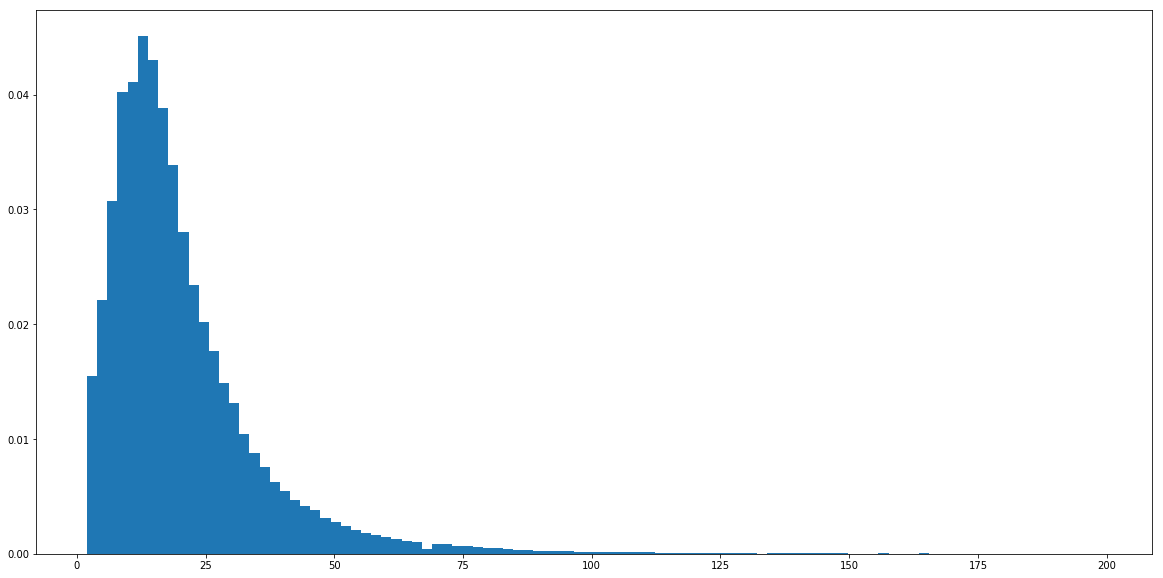

In [22]:
plt.figure(figsize=(20,10))
plt.hist([s for s in s_len if s<200], bins=100, normed=True) #[s for s in s_len if s<200]
#plt.yscale('log', nonposy='clip')
plt.show()

In [23]:
s_len_c = df_c['sentence'].apply(lambda s:len(s.split()))
s_len_nc = df_nc['sentence'].apply(lambda s:len(s.split()))

In [25]:
def hist_len(s_len):
    plt.figure(figsize=(20,10))
    plt.hist([s for s in s_len if s<200], bins=100, normed=True)
    #plt.yscale('log', nonposy='clip')
    plt.show()

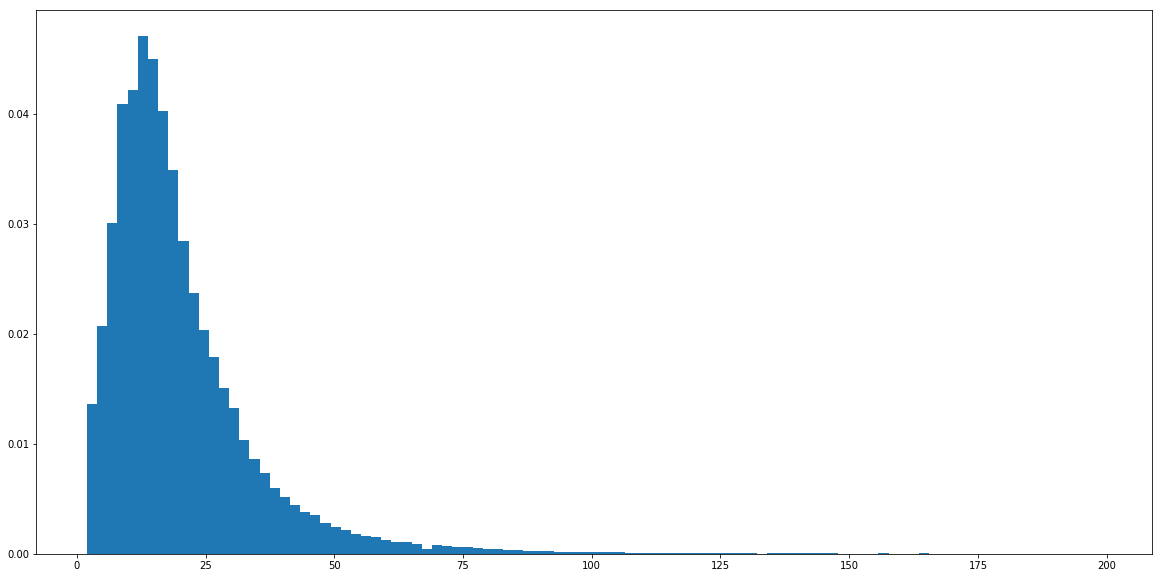

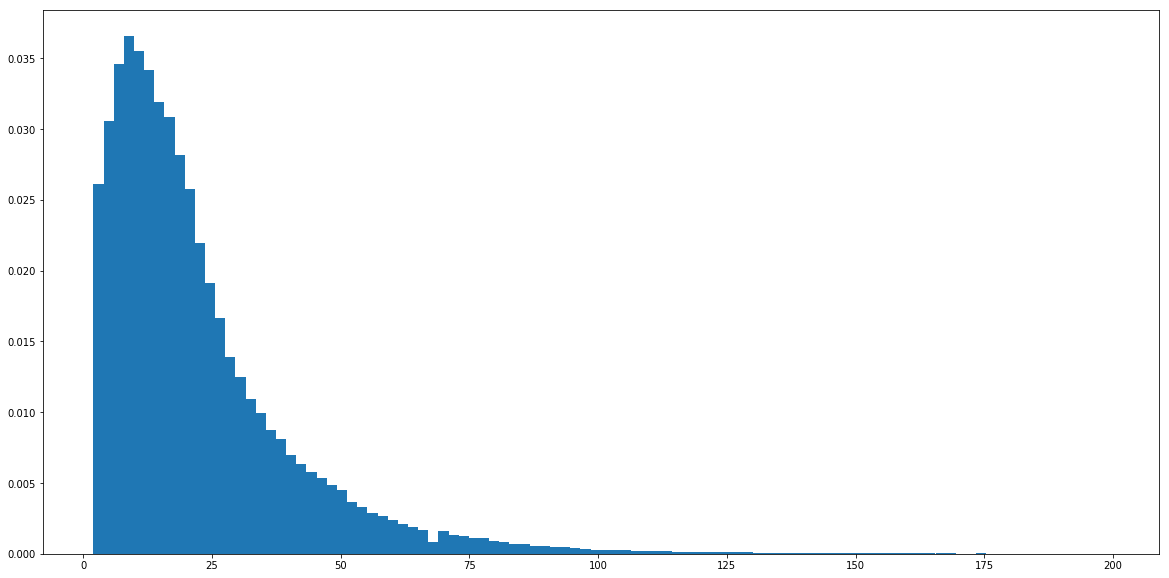

In [26]:
hist_len(s_len_c)
hist_len(s_len_nc)

## Distribuzione numero linee per file

In [27]:
lines_per_file = df[['filename','sentence']].groupby(['filename']).size()

In [28]:
print_column_stats(lines_per_file)

Mean 79.4113741592
Stddev 84.0475160841
Min 1
Max 1172


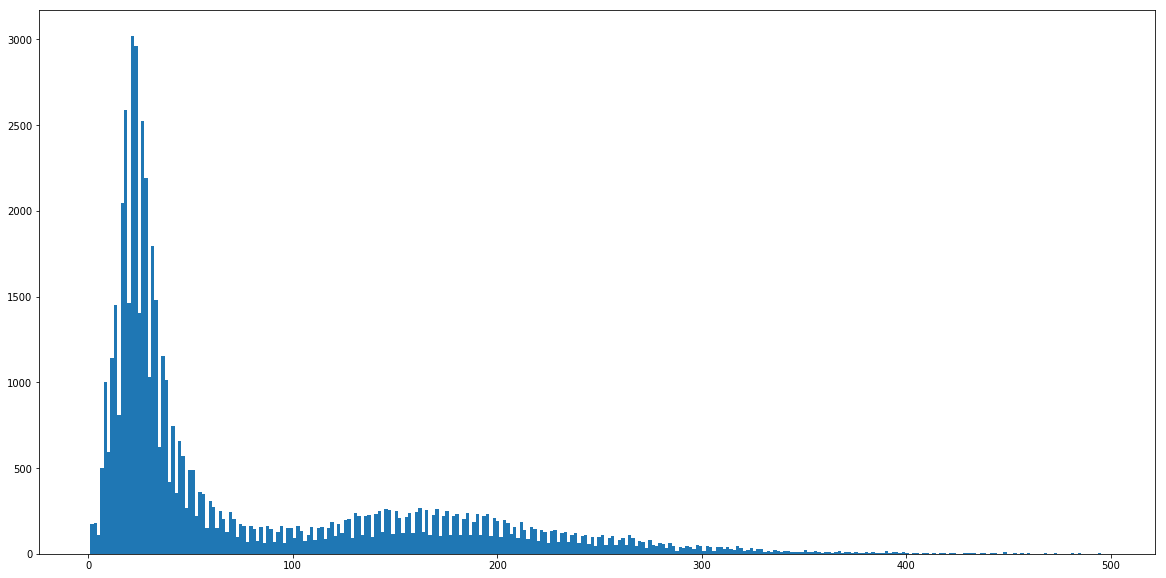

In [30]:
plt.figure(figsize=(20,10))
plt.hist([l for l in lines_per_file if l<500], bins=300)
#plt.yscale('log', nonposy='clip')
plt.show()

In [31]:
lines_per_file_nc = df_nc[['filename','sentence']].groupby(['filename']).size()
lines_per_file_c = df_c[['filename','sentence']].groupby(['filename']).size()

In [32]:
print_column_stats(lines_per_file_c)
print_column_stats(lines_per_file_nc)

Mean 95.3869486882
Stddev 91.6348524293
Min 1
Max 1172
Mean 40.693683455
Stddev 41.4254147224
Min 1
Max 934


In [33]:
def hist_lines(lines):
    plt.figure(figsize=(20,10))
    plt.hist([l for l in lines if l<300], bins=300)
    #plt.yscale('log', nonposy='clip')
    plt.show()

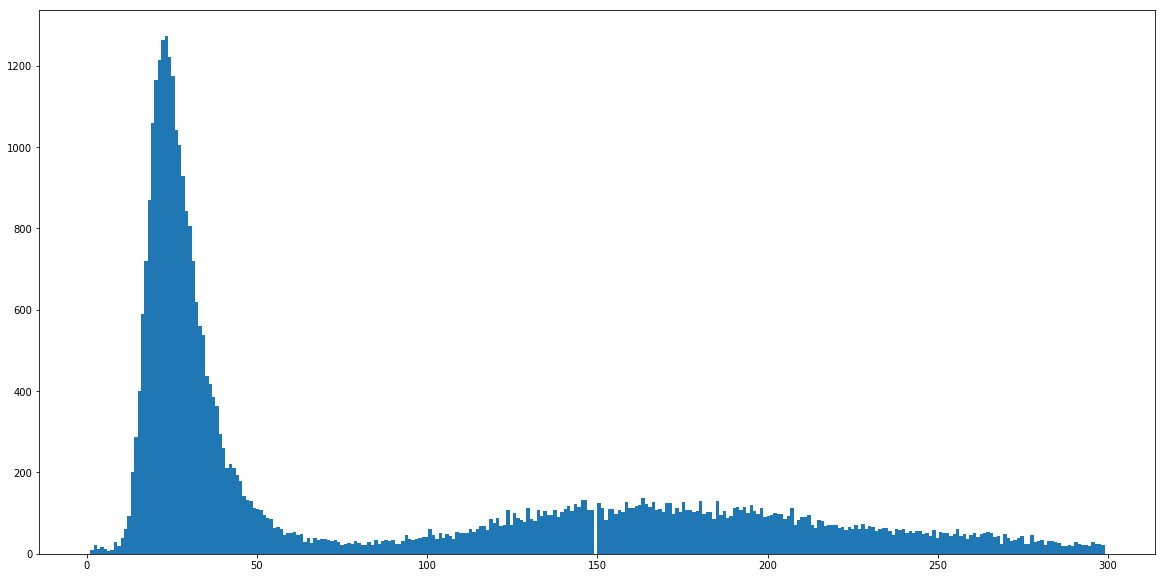

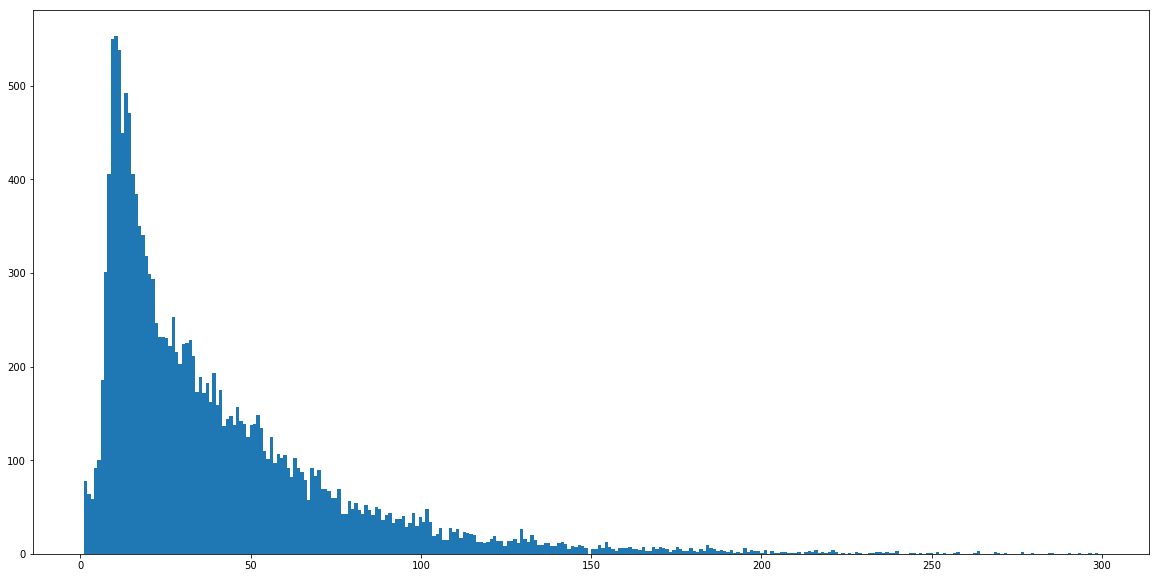

In [34]:
hist_lines(lines_per_file_c)
hist_lines(lines_per_file_nc)

## NLTK test

In [3]:
'''
import nltk
import re
from nltk.tokenize import WordPunctTokenizer
#tokenizer = nltk.data.load('tokenizers/punkt/italian.pickle')
word_tokenizer = WordPunctTokenizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('italian'))
import string
punctuation = set(string.punctuation)
'''
from lib.words import tokenize_doc, read_codec_file

In [54]:
def replace_num(word, num_repl=u'NUM', max_digits=1):
    return num_repl if word.isnumeric() and len(word)>max_digits else word

def replace_alnum(word, alnum_repl=u'ALPHANUM', max_digits=1):
    return alnum_repl if re.search('\d', word) != None and len(word)>max_digits else word

def contains_punctuation(word):
    sw = set(word)
    return len(sw-punctuation)<len(sw)

def split_sents(doc):
    return [s for s in re.split(u'[.;!?]', doc) if len(s)>0]

def tokenize_doc(doc, min_words=2):
    txt = replace_evil_dots_and_underscores(doc)
    #print txt
    sents = split_sents(txt) #tokenizer.sentences_from_text(txt)
    sents_words = word_tokenizer.tokenize_sents(sents)
    splitted_sents = []
    for sentence in sents_words:
        sent = [replace_alnum(replace_num(word)) for word in sentence if not contains_punctuation(word) and word not in stop_words]
        if len(sent)>=min_words:
            splitted_sents.append(sent)
    return splitted_sents

In [4]:
s = u'''ciao\n\n\n. eravamo in sei come va? questa è una super S.P.A. frase ART. perché affronterà;
allorchè §§§ 1 1223. molto bene\n ciao\n muahah\n\n.'''

#for s in tokenize_doc(s,1):
 #   for w in s:
  #      print w



for s in tokenize_doc(s, min_words=1):
    print ' '.join(s)

ciao
va
super SPA frase ART affronterà
allorchè §§§ 1 NUM molto bene ciao muahah


In [5]:
sents =  tokenize_doc(read_codec_file('../atti_costitutivi_txt/4957502190001.txt'), min_words=2)
for s in sents:
    print ' '.join(s)


N NUM Repertorio N NUM Raccolta ATTO COSTITUTIVO DI SOCIETA A RESPONSABILITA LIMITATA REPUBBLICA ITALIANA L otto marzo duemiladiciassette
In Caserta Corso Trieste n NUM Innanzi me Avv ONOFRIO CAPRIO Notaio Orta Atella studio ivi via Fabrizio De Andrè n NUM iscritto Ruolo Distretto Notarile Santa Maria Capua Vetere INTERVENGONO 1 GUARRO Gennaro nato Torre Greco NA 8 maggio NUM domiciliato Caserta frazione Tredici Via I ° Ottobre n 4 codice fiscale GRR GNR ALPHANUM ALPHANUM
2 GUARRO Ernesto nato Torre Greco NA 7 dicembre NUM domiciliato Caserta Via Perlasca n NUM codice fiscale GRR RST ALPHANUM ALPHANUM
3 FERRACANE Emanuela nata Napoli 5 marzo NUM domiciliata Caserta frazione Tredici Via I ° Ottobre n 4 codice fiscale FRR MNL ALPHANUM ALPHANUM
4 LUBRANO GIUNNO Maria Rosaria nata Napoli NUM giugno NUM domiciliata Caserta Via Perlasca n NUM codice fiscale LBR MRS ALPHANUM ALPHANUM Dell identità personale costituiti cittadini italiani Notaio certo
Articolo 1 I comparenti GUARRO Gennaro GUAR